**Level 3**

**(Advanced)**


Task 1: Build a Random Forest Classifier

Description: Implement a Random Forest model for classification on a complex dataset.

Objectives:

1. Train a Random Forest model and tune hyperparameters (e.g., number of trees, max depth).

2. Evaluate the model using cross-validation and classification metrics (precision, recall, F1-score).

3. Perform feature importance analysis to identify the most important features in the dataset.

4. Tools: Python, scikit-learn, pandas, matplotlib.

**Step 0 — Setup & Imports**

In [1]:
# Core data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing + model pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Model
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)


**Step 1 — Load Data (80% train, 20% test)**

In [4]:
# Paths (already in Colab /content)
TRAIN_PATH = "/content/churn-bigml-80.csv"
TEST_PATH  = "/content/churn-bigml-20.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print("Train shape:", df_train.shape, " | Test shape:", df_test.shape)
display(df_train.head())


Train shape: (2666, 20)  | Test shape: (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Step 2 — Define Target & Features + Gentle Cleaning**

Our target is Churn. We drop “charge” columns because they are just minutes × fixed rate (perfect collinearity).

In [5]:
# Target: 1 = churn, 0 = stay
y_train = df_train["Churn"].astype(int)
y_test  = df_test["Churn"].astype(int)

# Features
X_train = df_train.drop(columns=["Churn"])
X_test  = df_test.drop(columns=["Churn"])

# Drop perfectly collinear "charge" columns to avoid leakage/weird importance
CHARGE_COLS = ["Total day charge", "Total eve charge", "Total night charge", "Total intl charge"]
X_train = X_train.drop(columns=[c for c in CHARGE_COLS if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in CHARGE_COLS if c in X_test.columns])

# Column splits (treat Area code as categorical)
cat_cols = [c for c in ["State", "International plan", "Voice mail plan", "Area code"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical:", cat_cols)
print("Numeric    :", num_cols)

# Sanity check: missing values?
print("\nMissing values (train):")
print(X_train.isna().sum())


Categorical: ['State', 'International plan', 'Voice mail plan', 'Area code']
Numeric    : ['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Customer service calls']

Missing values (train):
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total eve minutes         0
Total eve calls           0
Total night minutes       0
Total night calls         0
Total intl minutes        0
Total intl calls          0
Customer service calls    0
dtype: int64


**Step 3 — Build a Clean Pipeline (Preprocess → RandomForest)**

One-Hot Encode categorical columns; passthrough numeric ones (RF doesn’t need scaling).

In [6]:
# Preprocessing:
# - Categorical: OneHotEncoder with "ignore" so unseen test categories don't crash
# - Numeric: passthrough (no scaling needed for trees)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# Base Random Forest (a good, sensible starting point)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",     # churn is imbalanced
    random_state=42,
    n_jobs=-1
)

# End-to-end pipeline
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

# Train
rf_pipe.fit(X_train, y_train)
print("Random Forest trained!")


Random Forest trained!


**Step 4 — Test-Set Evaluation (Accuracy, Precision, Recall, F1, AUC)**

We judge on the held-out test file so we get honest numbers.

In [7]:
# Predictions and probabilities
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC      : {auc:.3f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.925
Precision: 0.979
Recall   : 0.484
F1-score : 0.648
AUC      : 0.922

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       572
           1       0.98      0.48      0.65        95

    accuracy                           0.93       667
   macro avg       0.95      0.74      0.80       667
weighted avg       0.93      0.93      0.91       667

Confusion Matrix:
 [[571   1]
 [ 49  46]]


**Step 5 — ROC Curve (visual proof of discrimination)**

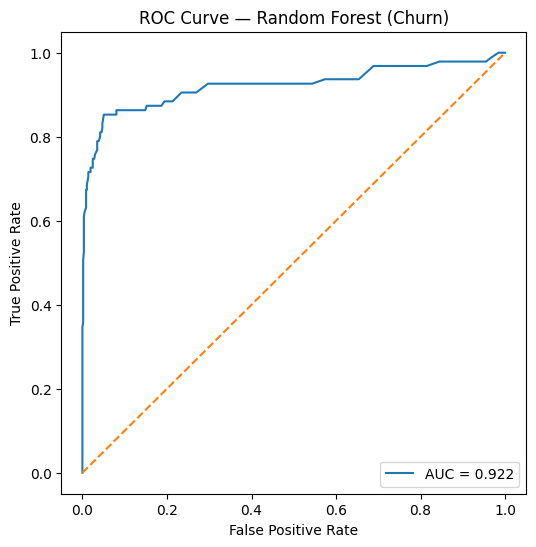

In [8]:
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest (Churn)")
plt.legend(loc="lower right")
plt.show()


**Step 6 — Cross-Validation (Stratified, on Training Set)**

We cross-validate to see stability before tuning.

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1 focuses on positive class quality; you can also try "roc_auc" here
cv_f1 = cross_val_score(rf_pipe, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
cv_auc = cross_val_score(rf_pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

print("CV F1 scores :", np.round(cv_f1, 3))
print("Mean F1      :", cv_f1.mean().round(3))
print("CV AUC scores:", np.round(cv_auc, 3))
print("Mean AUC     :", cv_auc.mean().round(3))


CV F1 scores : [0.672 0.556 0.678 0.638 0.615]
Mean F1      : 0.632
CV AUC scores: [0.911 0.931 0.907 0.892 0.921]
Mean AUC     : 0.913


**Step 7 — Hyperparameter Tuning (Small, Sensible Grid)**

This grid runs quickly in Colab but still finds better settings. Expand if you’ve got time.

In [10]:
param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"]
}

grid_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1",          # optimize for catching churners with precision/recall balance
    cv=grid_cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1 :", grid.best_score_.round(3))

# Replace pipeline with best-found model
best_rf_pipe = grid.best_estimator_

# Re-evaluate on test
y_pred_best = best_rf_pipe.predict(X_test)
y_prob_best = best_rf_pipe.predict_proba(X_test)[:, 1]

acc_b  = accuracy_score(y_test, y_pred_best)
prec_b = precision_score(y_test, y_pred_best, zero_division=0)
rec_b  = recall_score(y_test, y_pred_best, zero_division=0)
f1_b   = f1_score(y_test, y_pred_best)
auc_b  = roc_auc_score(y_test, y_prob_best)

print("\n== Test metrics with tuned RF ==")
print(f"Accuracy : {acc_b:.3f}")
print(f"Precision: {prec_b:.3f}")
print(f"Recall   : {rec_b:.3f}")
print(f"F1-score : {f1_b:.3f}")
print(f"AUC      : {auc_b:.3f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
Best CV F1 : 0.769

== Test metrics with tuned RF ==
Accuracy : 0.939
Precision: 0.865
Recall   : 0.674
F1-score : 0.757
AUC      : 0.925


**Step 8 — Feature Importance (What’s driving churn?)**

We pull feature names after encoding and pair them with the forest’s importances.

Top 15 important features:


,Feature,Importance
60,Total day minutes,0.207591
68,Customer service calls,0.138600
62,Total eve minutes,0.069331
52,International plan_Yes,0.055115
66,Total intl minutes,0.055046
64,Total night minutes,0.053043
51,International plan_No,0.052960
61,Total day calls,0.041018
67,Total intl calls,0.040077
58,Account length,0.038425


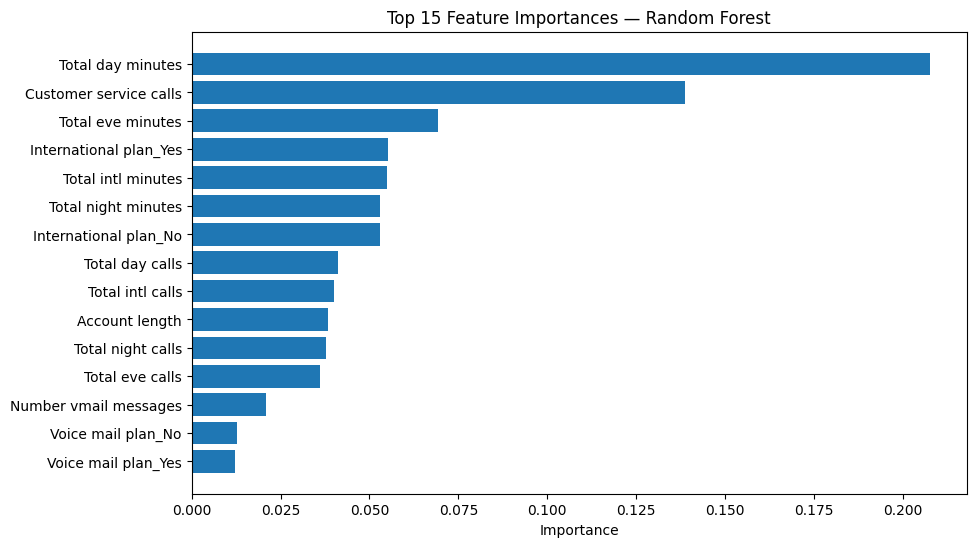

In [11]:
# Grab the fitted OneHotEncoder to list categorical feature names
ohe = best_rf_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_names = cat_names + num_cols

importances = best_rf_pipe.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"Feature": all_names, "Importance": importances}) \
             .sort_values("Importance", ascending=False)

print("Top 15 important features:")
display(feat_imp.head(15))

# Simple horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"].head(15), feat_imp["Importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.show()


**Step 9 — Threshold Tuning (precision vs recall trade-off)**

Default threshold 0.50 may not match business goals. Let’s see options.

In [12]:
def metrics_at_threshold(y_true, y_scores, thr):
    y_hat = (y_scores >= thr).astype(int)
    return {
        "thr": thr,
        "acc": accuracy_score(y_true, y_hat),
        "prec": precision_score(y_true, y_hat, zero_division=0),
        "rec": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat)
    }

print("Threshold  |  Acc   Prec  Rec   F1")
for thr in [0.30, 0.40, 0.50, 0.60, 0.70]:
    m = metrics_at_threshold(y_test, y_prob_best, thr)
    print(f"{m['thr']:.2f}        {m['acc']:.3f}  {m['prec']:.3f} {m['rec']:.3f} {m['f1']:.3f}")


Threshold  |  Acc   Prec  Rec   F1
0.30        0.897  0.594 0.863 0.704
0.40        0.924  0.700 0.811 0.751
0.50        0.939  0.865 0.674 0.757
0.60        0.924  0.978 0.474 0.638
0.70        0.892  1.000 0.242 0.390


**Step 10 — Mini Report**

In [13]:
report = f"""
Random Forest Classifier — Customer Churn (Level 3)

Data
- Train: {len(X_train):,} rows   |   Test: {len(X_test):,} rows
- Positive class (churn) is minority ⇒ handled via class_weight='balanced'

Preprocessing
- Categorical: OneHotEncoder on {cat_cols}
- Numeric: passthrough (trees don’t require scaling)
- Dropped perfectly collinear charge columns: {CHARGE_COLS}

Cross-Validation (train)
- Stratified 5-fold F1: {cross_val_score(rf_pipe, X_train, y_train,
   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
   scoring="f1").mean():.3f}

Hyperparameter Tuning (GridSearchCV, scoring=F1)
- Best parameters: {grid.best_params_}
- Best CV F1: {grid.best_score_:.3f}

Test-Set Performance (tuned model, threshold=0.50)
- Accuracy:  {acc_b:.3f}
- Precision: {prec_b:.3f}
- Recall:    {rec_b:.3f}
- F1-score:  {f1_b:.3f}
- AUC:       {auc_b:.3f}

Interpretation
- Top drivers of churn are shown by feature importances (see plot/table).
- Threshold tuning illustrates the precision vs. recall trade-off for outreach campaigns.

Conclusion
- Random Forest improves robustness on non-linear patterns vs. logistic regression,
  while keeping interpretation via feature importances. For production, consider
  calibrated probabilities and business-aligned thresholds.
""".strip()

print(report)


Random Forest Classifier — Customer Churn (Level 3)

Data
- Train: 2,666 rows   |   Test: 667 rows
- Positive class (churn) is minority ⇒ handled via class_weight='balanced'

Preprocessing
- Categorical: OneHotEncoder on ['State', 'International plan', 'Voice mail plan', 'Area code']
- Numeric: passthrough (trees don’t require scaling)
- Dropped perfectly collinear charge columns: ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

Cross-Validation (train)
- Stratified 5-fold F1: 0.632

Hyperparameter Tuning (GridSearchCV, scoring=F1)
- Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
- Best CV F1: 0.769

Test-Set Performance (tuned model, threshold=0.50)
- Accuracy:  0.939
- Precision: 0.865
- Recall:    0.674
- F1-score:  0.757
- AUC:       0.925

Interpretation
- Top drivers of churn are shown by feature importances (see plot/table).
- 